In [9]:
import pandas as pd
import numpy as np
import os #운영체제 모듈
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix #혼돈행렬(Confusion Matrix)
from mlxtend.plotting import plot_confusion_matrix # mlxtend 모듈은 데이터의 전처리부터 분류, 군집 등의 모델링까지 머신 러닝 기능을 제공

from keras import models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.utils import to_categorical

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
data = pd.read_csv('/content/drive/MyDrive/icml_face_data.csv')
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [12]:
def prepare_data(data):
    """ Prepare data for modeling
        input: data frame with labels und pixel data
        output: image and label array """

    image_array = np.zeros(shape=(len(data), 48, 48))
    #  0으로만 채워진 3차원 array를 생성합니다. 48행 48열, data개수만큼
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        # the fromstring() function is used to create a new 1D (one-dimensional) array from a string that contains data.
        image = np.reshape(image, (48, 48))
        # reshape함수는 현재의 배열의 차원(1차원,2차원,3차원)을 변경하여 행렬을 반환하거나 하는 경우에 많이 이용되는 함수입니다.
        # image 1차원 배열을 48행 48열 행렬로 변환합니다.
        image_array[i] = image

    return image_array, image_label

def plot_examples(label=0):
    fig, axs = plt.subplots(1, 5, figsize=(25, 12)) # subplot() 함수는 여러 개의 그래프를 하나의 그림에 나타내도록 합니다.
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel() # Numpy 다차원 배열을 1차원으로 바꾸는 것
    for i in range(5):
        idx = data[data['emotion']==label].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([]) # 눈금 이름 설정하기 : set_xticklabels(), set_yticklabels()
        axs[i].set_yticklabels([])

def plot_all_emotions():
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    """ Function to plot the image and compare the prediction results with the label """

    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)

    bar_label = emotions.values()

    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])

    axs[1].bar(bar_label, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].grid()

    plt.show()

def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1) # 행(axis = 0) 또는 열(axis = 1)을 따라 가장 큰 값의 색인을 찾습니다.
    df_array2['emotion'] = array2.argmax(axis=1)

    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()

    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    ''' y 세트에는 이미지에서 실제로 감지된 감정 이름이 포함되어 있습니다.
     difference() 메서드는 두 집합 사이의 차이를 취합니다.
     이는 감정 세트에는 있지만 y 세트에는 없는 모든 감정의 목록을 반환한다는 것을 의미합니다.
     'key_missed' 변수에는 이미지에서 놓친 감정 목록이 포함되어 있습니다.
    '''
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].grid()

    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()

    plt.show()

In [13]:
data[' Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name:  Usage, dtype: int64

In [14]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [15]:
train_image_array, train_image_label = prepare_data(data[data[' Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data[' Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(data[data[' Usage']=='PublicTest'])

In [16]:
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255
val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255
test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

In [17]:
train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)

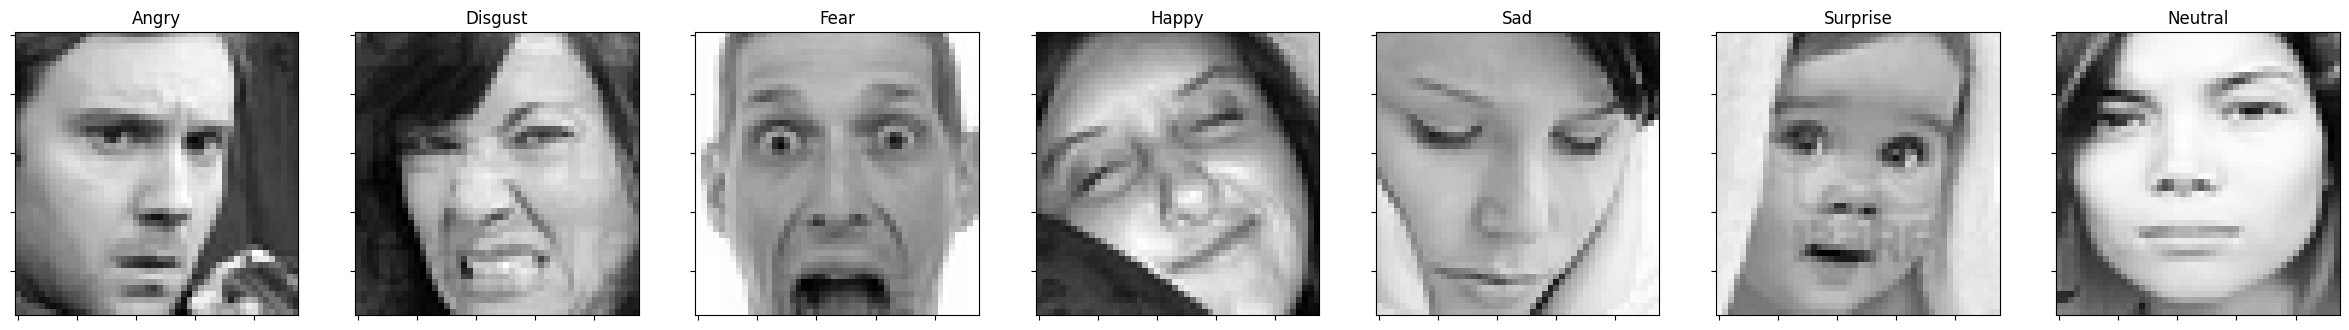

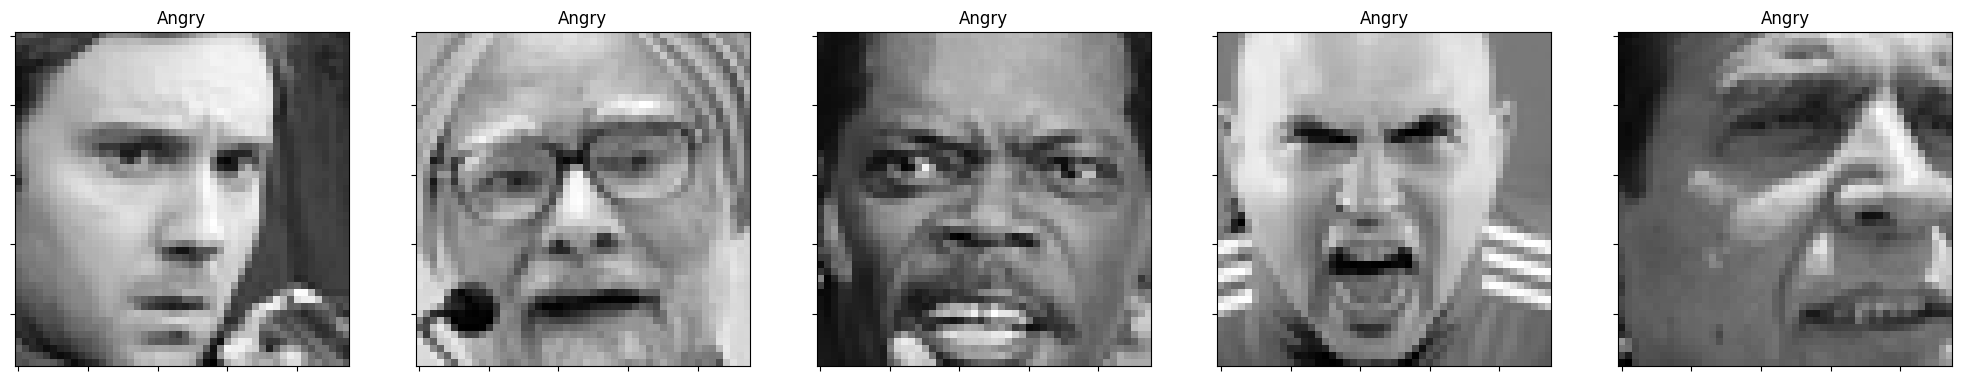

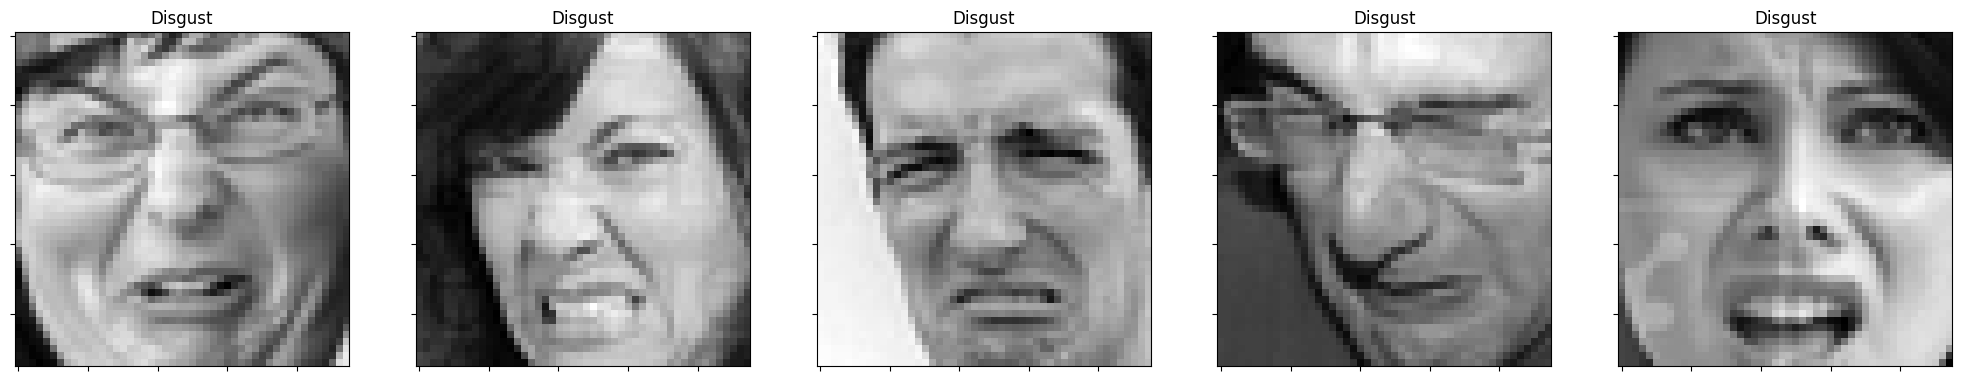

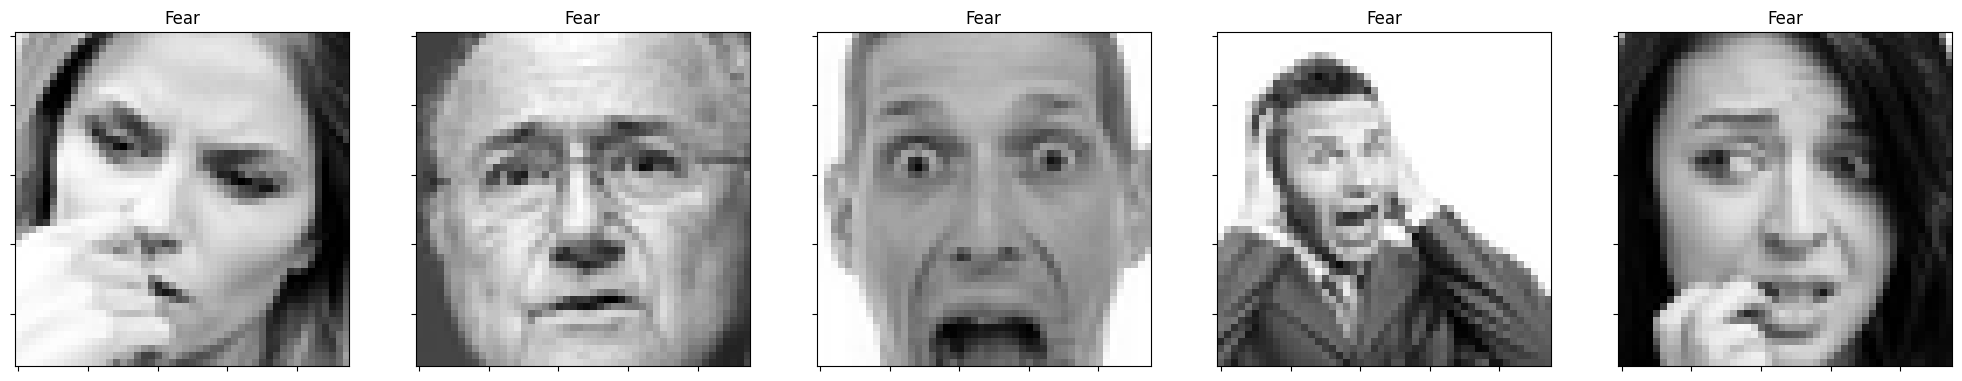

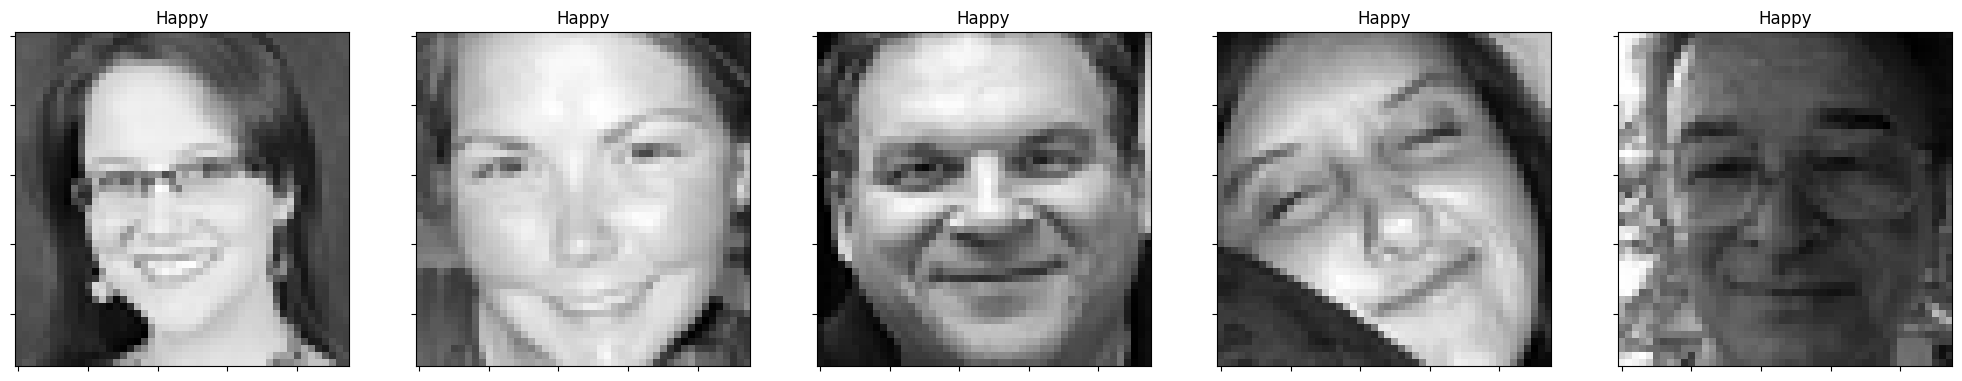

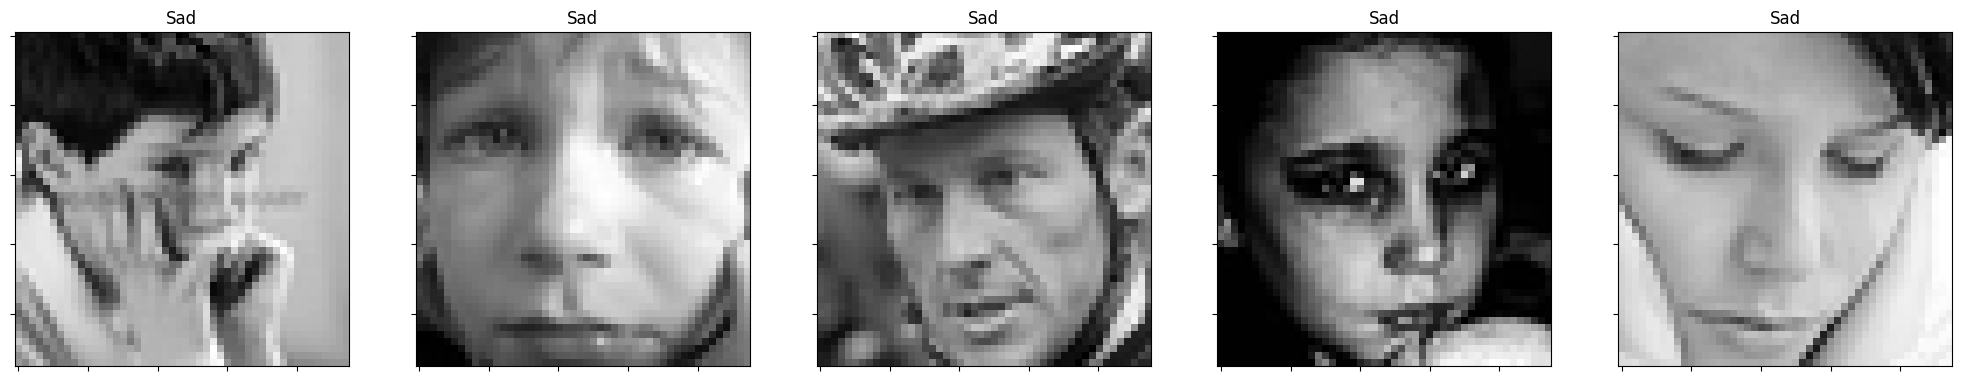

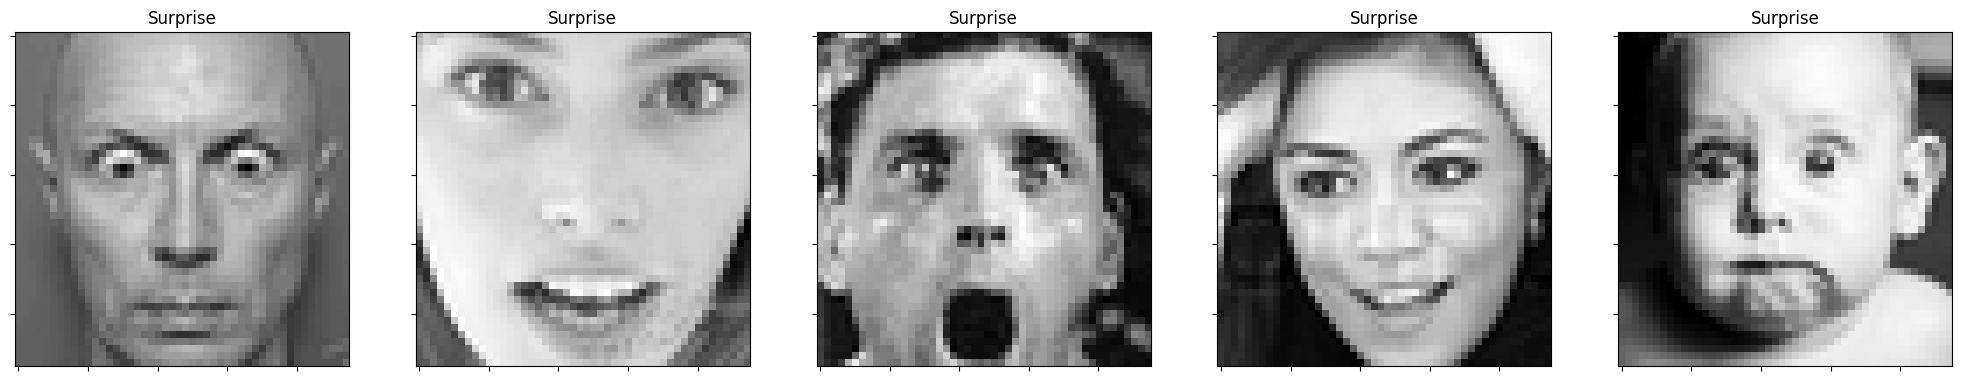

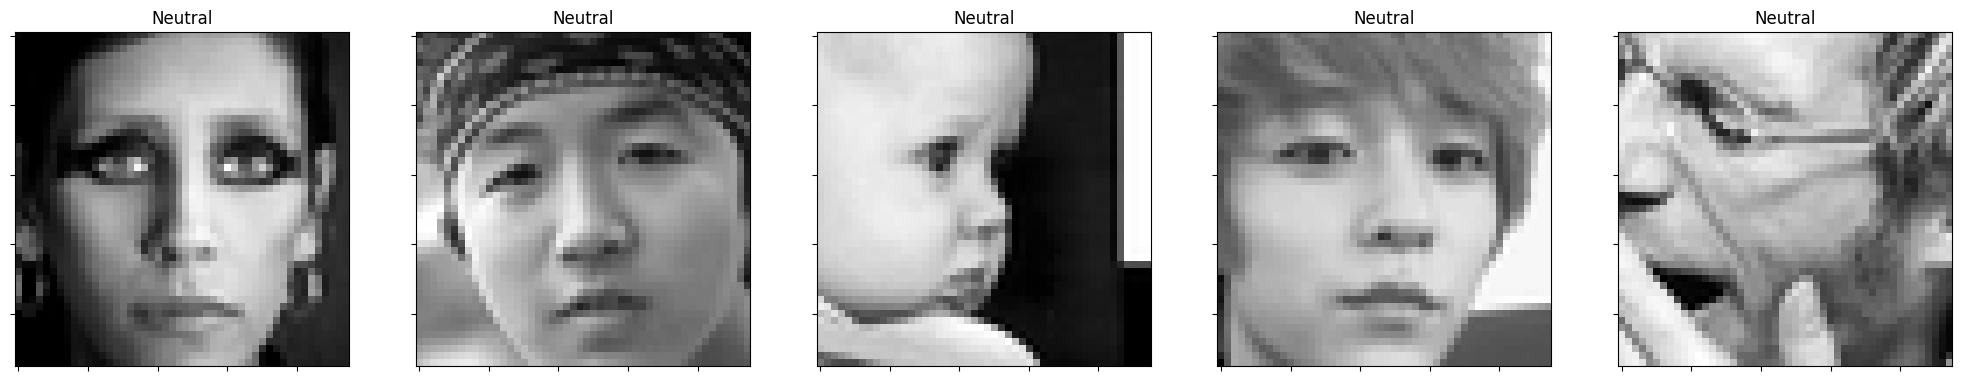

In [18]:
#All Emotions
plot_all_emotions()
#Angry
plot_examples(label=0)
#Disgust
plot_examples(label=1)
#Fear
plot_examples(label=2)
#Happy
plot_examples(label=3)
#Sad
plot_examples(label=4)
#Surprise
plot_examples(label=5)
#Neutral
plot_examples(label=6)

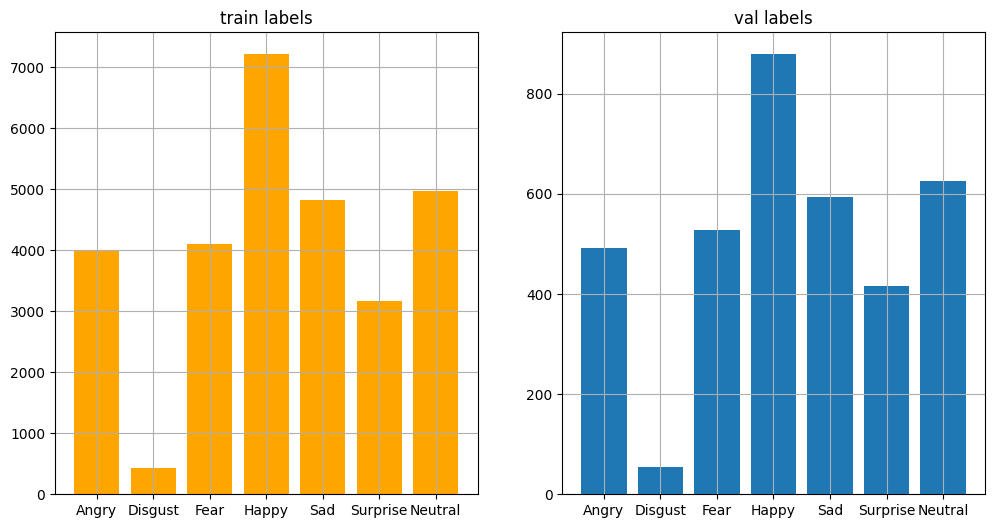

In [19]:
plot_compare_distributions(train_labels, val_labels, title1='train labels', title2='val labels')

In [20]:
class_weight = dict(zip(range(0, 7), (((data[data[' Usage']=='Training']['emotion'].value_counts()).sort_index())/len(data[data[' Usage']=='Training']['emotion'])).tolist()))

In [21]:
class_weight

{0: 0.1391549688251071,
 1: 0.01518687519593159,
 2: 0.14270786164617366,
 3: 0.2513149186666202,
 4: 0.16823992476226968,
 5: 0.11045316799609878,
 6: 0.17294228290779895}

## CNN모델 구현하기

In [22]:
model = models.Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(7, activation='softmax'))

In [23]:
model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 128)         0

In [25]:
history = model.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    class_weight = class_weight,
                    epochs=200,
                    batch_size=64)

Epoch 1/200
449/449 [==============================] - 13s 13ms/step - loss: 0.2903 - accuracy: 0.2525 - val_loss: 1.7833 - val_accuracy: 0.2566
Epoch 2/200
449/449 [==============================] - 4s 9ms/step - loss: 0.2389 - accuracy: 0.3934 - val_loss: 1.4524 - val_accuracy: 0.4425
Epoch 3/200
449/449 [==============================] - 4s 9ms/step - loss: 0.2089 - accuracy: 0.4700 - val_loss: 1.4791 - val_accuracy: 0.4700
Epoch 4/200
449/449 [==============================] - 5s 11ms/step - loss: 0.1945 - accuracy: 0.5105 - val_loss: 1.2929 - val_accuracy: 0.5249
Epoch 5/200
449/449 [==============================] - 4s 9ms/step - loss: 0.1828 - accuracy: 0.5442 - val_loss: 1.2337 - val_accuracy: 0.5408
Epoch 6/200
449/449 [==============================] - 4s 9ms/step - loss: 0.1722 - accuracy: 0.5718 - val_loss: 1.2234 - val_accuracy: 0.5428
Epoch 7/200
449/449 [==============================] - 4s 10ms/step - loss: 0.1627 - accuracy: 0.5987 - val_loss: 1.1804 - val_accuracy: 0.

In [26]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('test caccuracy:', test_acc)

113/113 [==============================] - 1s 3ms/step - loss: 5.9457 - accuracy: 0.5495
test caccuracy: 0.5494566559791565


In [27]:
pred_test_labels = model.predict(test_images)

113/113 [==============================] - 0s 2ms/step


## Convergence 분석

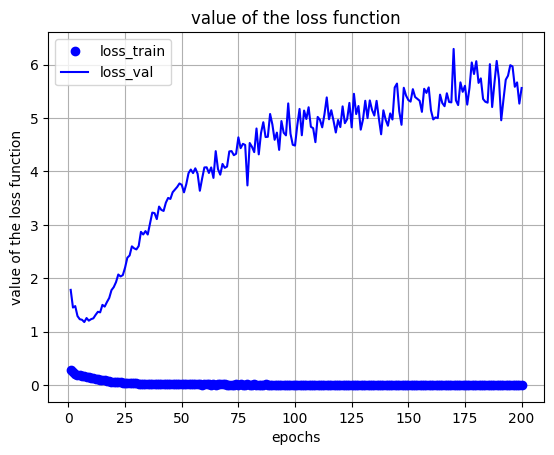

In [28]:
loss = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

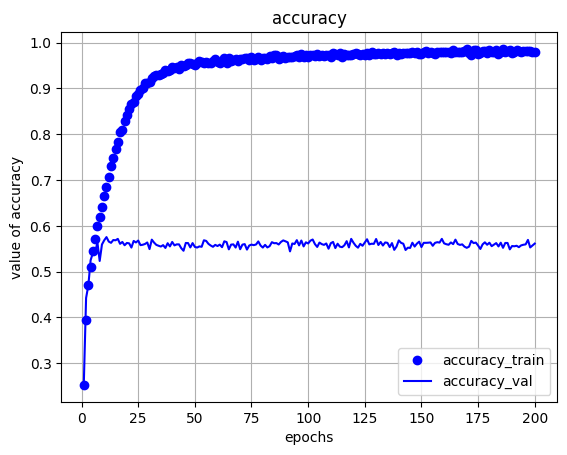

In [29]:
acc = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='accuracy_train')
plt.plot(epochs, acc_val, 'b', label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

## 결과분석

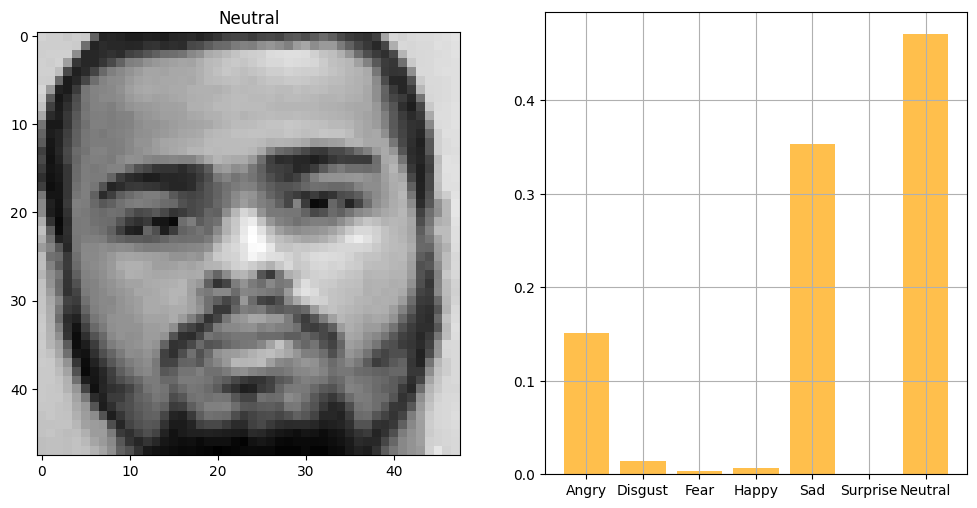

In [30]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 106)

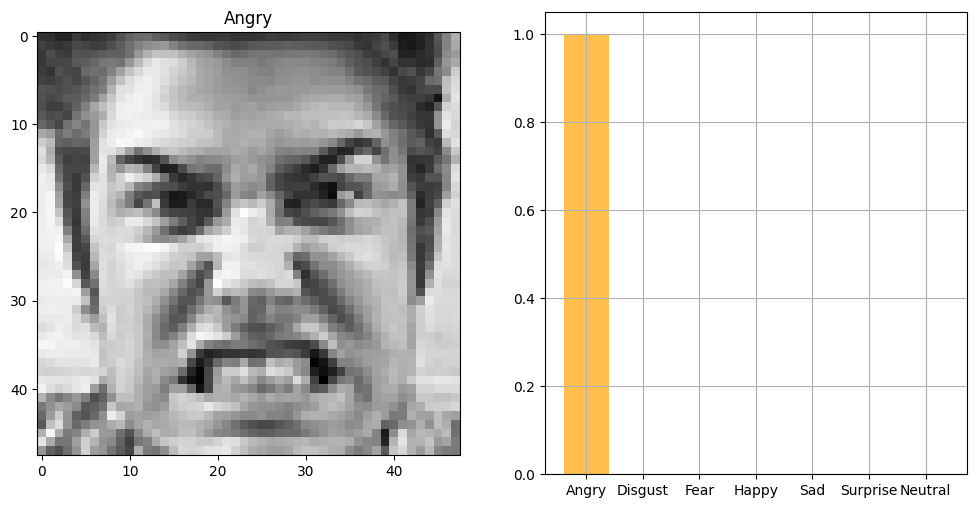

In [31]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 40)

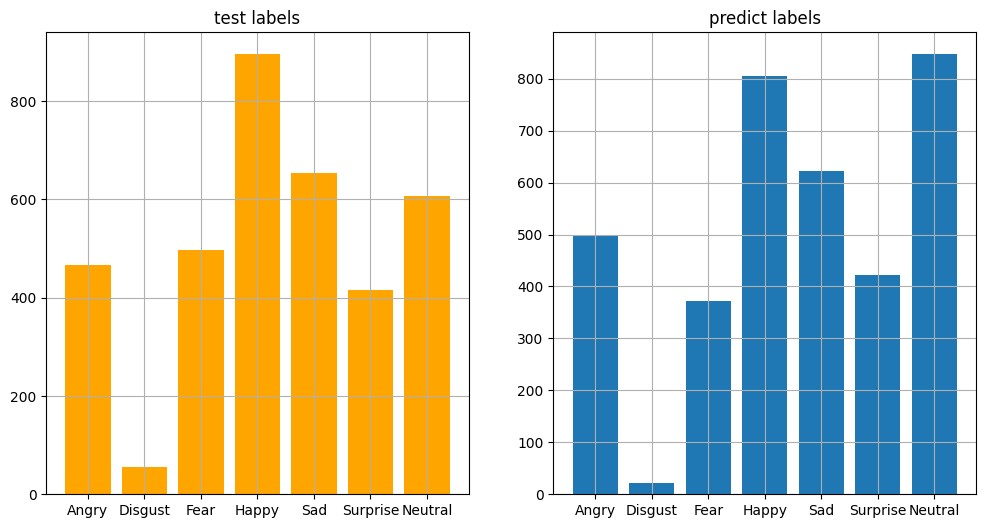

In [32]:
plot_compare_distributions(test_labels, pred_test_labels, title1='test labels', title2='predict labels')

## Wrong Prediction 분석

In [33]:
df_compare = pd.DataFrame()
df_compare['real'] = test_labels.argmax(axis=1)
df_compare['pred'] = pred_test_labels.argmax(axis=1)
df_compare['wrong'] = np.where(df_compare['real']!=df_compare['pred'], 1, 0)

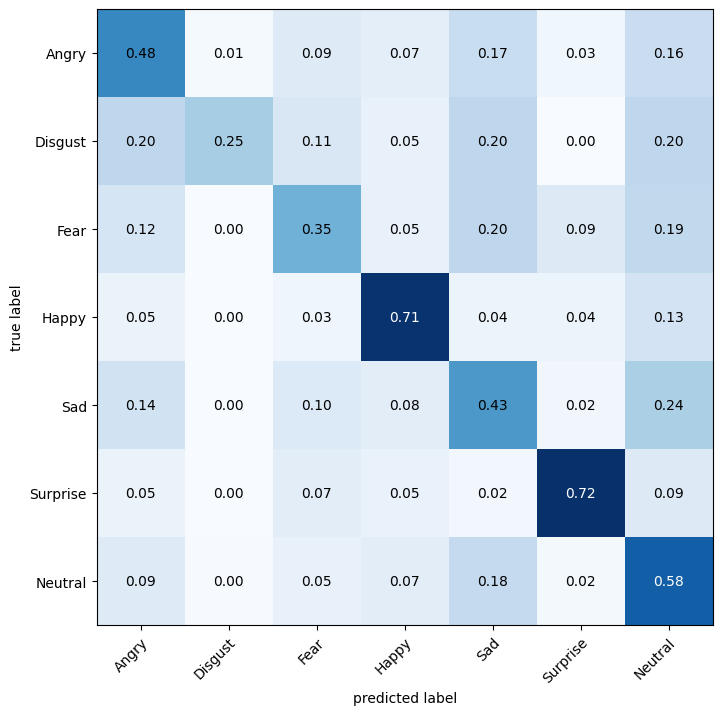

In [34]:
conf_mat = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels.argmax(axis=1))

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotions.values(),
                                figsize=(8, 8))
fig.show()

In [35]:
model.save('face_recognition_model.h5')  # 모델을 HDF5 파일로 저장

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [36]:
from keras.models import load_model

# 모델을 새로운 객체로 불러옵니다
loaded_model = load_model('face_recognition_model.h5')

In [37]:
from keras.preprocessing import image
import numpy as np

def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(48, 48), color_mode="grayscale")
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255  # Normalize to [0, 1]
    return img

# 예시 이미지 경로
image_path = '/content/angry.PNG'  # 경로에 이미지가 저장되어 있다고 가정합니다.

# 이미지를 불러오고 전처리합니다
test_image = load_and_preprocess_image(image_path)

In [38]:
# 모델을 사용하여 예측 수행
predictions = loaded_model.predict(test_image)
predicted_class = np.argmax(predictions, axis=1)
predicted_emotion = emotions[predicted_class[0]]

print("Predicted Emotion:", predicted_emotion)

1/1 [==============================] - 0s 301ms/step
Predicted Emotion: Angry


In [39]:
# 예시 이미지 경로
image_path = '/content/disgust.PNG'  # 경로에 이미지가 저장되어 있다고 가정합니다.

# 이미지를 불러오고 전처리합니다
test_image = load_and_preprocess_image(image_path)

# 모델을 사용하여 예측 수행
predictions = loaded_model.predict(test_image)
predicted_class = np.argmax(predictions, axis=1)
predicted_emotion = emotions[predicted_class[0]]

print("Predicted Emotion:", predicted_emotion)

1/1 [==============================] - 0s 26ms/step
Predicted Emotion: Sad


In [40]:
# 예시 이미지 경로
image_path = '/content/fear.PNG'  # 경로에 이미지가 저장되어 있다고 가정합니다.

# 이미지를 불러오고 전처리합니다
test_image = load_and_preprocess_image(image_path)

# 모델을 사용하여 예측 수행
predictions = loaded_model.predict(test_image)
predicted_class = np.argmax(predictions, axis=1)
predicted_emotion = emotions[predicted_class[0]]

print("Predicted Emotion:", predicted_emotion)

1/1 [==============================] - 0s 26ms/step
Predicted Emotion: Fear


In [41]:
# 예시 이미지 경로
image_path = '/content/happy.PNG'  # 경로에 이미지가 저장되어 있다고 가정합니다.

# 이미지를 불러오고 전처리합니다
test_image = load_and_preprocess_image(image_path)

# 모델을 사용하여 예측 수행
predictions = loaded_model.predict(test_image)
predicted_class = np.argmax(predictions, axis=1)
predicted_emotion = emotions[predicted_class[0]]

print("Predicted Emotion:", predicted_emotion)

1/1 [==============================] - 0s 25ms/step
Predicted Emotion: Happy


In [42]:
# 예시 이미지 경로
image_path = '/content/neutral.PNG'  # 경로에 이미지가 저장되어 있다고 가정합니다.

# 이미지를 불러오고 전처리합니다
test_image = load_and_preprocess_image(image_path)

# 모델을 사용하여 예측 수행
predictions = loaded_model.predict(test_image)
predicted_class = np.argmax(predictions, axis=1)
predicted_emotion = emotions[predicted_class[0]]

print("Predicted Emotion:", predicted_emotion)

1/1 [==============================] - 0s 26ms/step
Predicted Emotion: Surprise


In [43]:
# 예시 이미지 경로
image_path = '/content/sad.PNG'  # 경로에 이미지가 저장되어 있다고 가정합니다.

# 이미지를 불러오고 전처리합니다
test_image = load_and_preprocess_image(image_path)

# 모델을 사용하여 예측 수행
predictions = loaded_model.predict(test_image)
predicted_class = np.argmax(predictions, axis=1)
predicted_emotion = emotions[predicted_class[0]]

print("Predicted Emotion:", predicted_emotion)

1/1 [==============================] - 0s 27ms/step
Predicted Emotion: Happy


In [44]:
# 예시 이미지 경로
image_path = '/content/surprise.PNG'  # 경로에 이미지가 저장되어 있다고 가정합니다.

# 이미지를 불러오고 전처리합니다
test_image = load_and_preprocess_image(image_path)

# 모델을 사용하여 예측 수행
predictions = loaded_model.predict(test_image)
predicted_class = np.argmax(predictions, axis=1)
predicted_emotion = emotions[predicted_class[0]]

print("Predicted Emotion:", predicted_emotion)

1/1 [==============================] - 0s 26ms/step
Predicted Emotion: Neutral
